In [60]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier, get_json_responses, SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION

In [61]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [62]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [63]:
def update_pricing_in_dataframe(df, model_name_col="model_name", input_token_col="total_input_tokens", output_token_col="total_output_tokens"):
    """
    Update pricing columns in a dataframe based on model_name and SIMPLE_MODEL_POOL_CONFIG.
    """
    for model_name in df[model_name_col].unique():
        if model_name not in SIMPLE_MODEL_POOL_CONFIG:
            print(f"Warning: {model_name} not found in SIMPLE_MODEL_POOL_CONFIG")
            continue
        
        input_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["input_per_mill"] / TOKENS_PER_MILLION
        output_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["output_per_mill"] / TOKENS_PER_MILLION
        
        mask = df[model_name_col] == model_name
        df.loc[mask, "input_cost_usd_once"] = df.loc[mask, input_token_col] * input_cost
        df.loc[mask, "total_output_cost_usd"] = df.loc[mask, output_token_col] * output_cost
        df.loc[mask, "total_cost_usd"] = df.loc[mask, "input_cost_usd_once"] + df.loc[mask, "total_output_cost_usd"]

In [64]:
# GENERATION_CONFIG
BASELINE_K=1
BASELINE_TEMP=0.0

PROBE_MODEL_DATA_SOURCE = "DigitalLearningGmbH_MATH-lighteval"
PROBE_PROBE_K=1
PROBE_PROBE_TEMP=0.0

ROUTING_MAX_K=1
ROUTING_TEMP=0.0
# ROUTER_OPTIONS="easy-3_hard-1_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-2_hard-4_medium-3_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5"
# ROUTER_OPTIONS="easy-8_hard-8_medium-8"
ROUTER_OPTIONS="greedy"

ROUTER_THRESHOLDS="E0.9_M0.4"
# ROUTER_THRESHOLDS="E0.8_M0.4"
# ROUTER_THRESHOLDS="E0.9_M0.3"

ROUTING_MODEL = "Qwen_Qwen2.5-Math-1.5B-Instruct"

In [65]:
def load_cascade_router_results(router_result_df_path):
    # cascade_df = pd.read_parquet("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/DigitalLearningGmbH_MATH-lighteval_routed/answered_bayes_cascade.parquet")
    cascade_df = pd.read_parquet(router_result_df_path)
    update_pricing_in_dataframe(cascade_df, model_name_col="route_to", input_token_col="input_num_tokens", output_token_col="response_num_tokens")

    cascade_sr_score = cascade_df["passk_score"].mean()
    cascade_majority_vote_score = cascade_df["majority_vote_is_correct"].mean()
    cascade_total_cost = cascade_df["total_cost_usd"].sum()

    print('===============================\n')
    print(f"Accuracy: {cascade_majority_vote_score}")
    print(f"Passk: {cascade_sr_score}")
    print(f"Cost: {cascade_total_cost}")
    print("Router question breakdown:")
    print(cascade_df['route_to'].value_counts())
    print('===============================\n')

    return cascade_majority_vote_score, cascade_sr_score, cascade_total_cost

In [66]:
router_res_df = load_cascade_router_results("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/openai_gsm8k_routed/answered_bayes_cascade.parquet")


Accuracy: 0.9021986353297953
Passk: 0.9021986353297953
Cost: 0.1454316
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    953
Qwen/Qwen2.5-Math-72B-Instruct     199
Qwen/Qwen2.5-Math-7B-Instruct      167
Name: count, dtype: int64




Accuracy: 0.2
Passk: 0.2
Cost: 0.0181024
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.018164700000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.0183249
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.3140407288317256
Passk: 0.3140407288317256
Cost: 0.6369567
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-7B-Instruct      473
Qwen/Qwen2.5-Math-72B-Instruct     429
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Name: count, dtype: int64


Accuracy: 0.3579849946409432
Passk: 0.3579849946409432
Cost: 0.9922704000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct     898
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Qwen/Qwen2.5-Ma

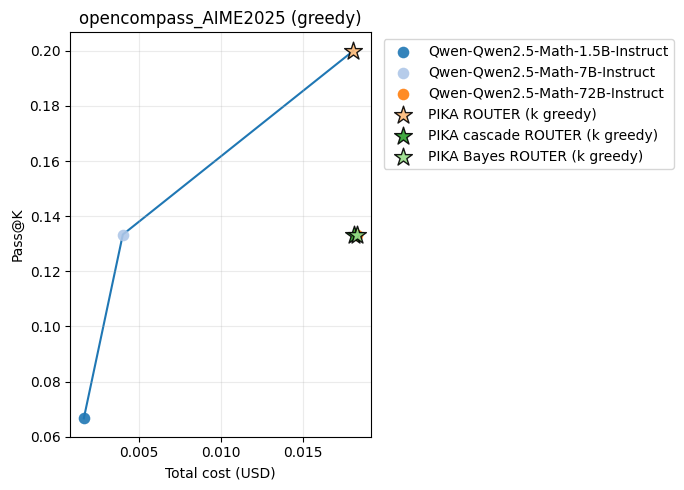

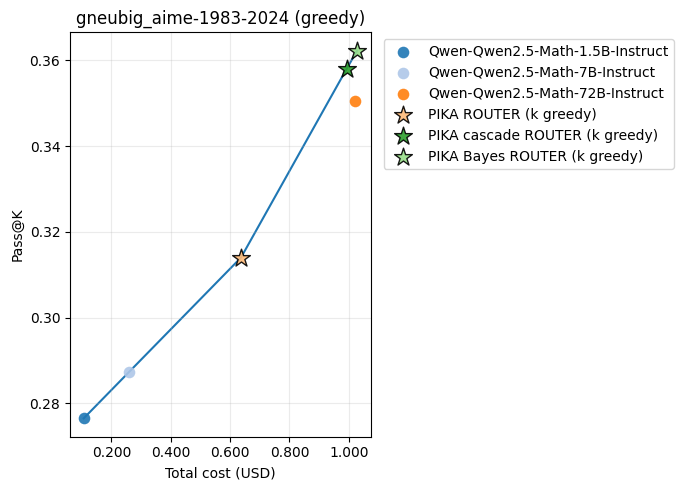

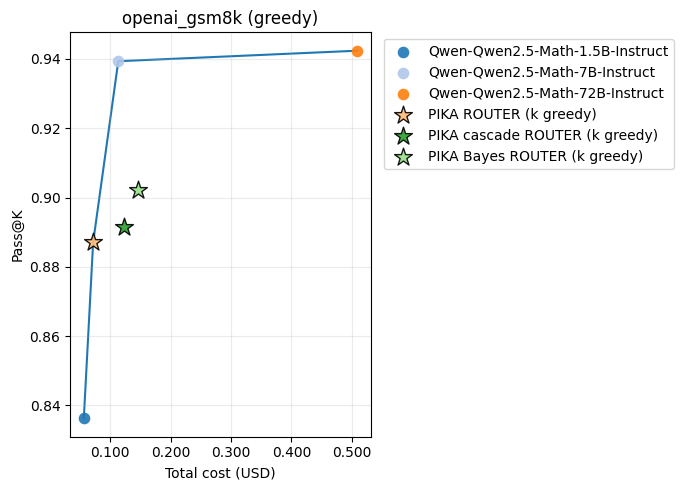

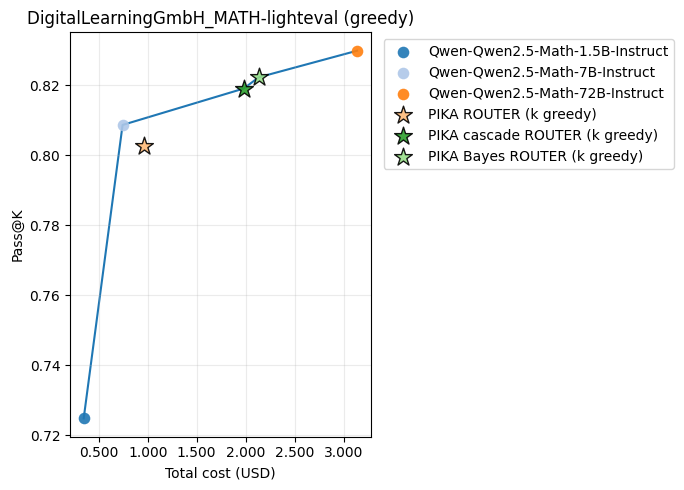

In [67]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)
        update_pricing_in_dataframe(BASELINE_BENCHMARK_DF)
        

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})

        
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

    PIKA_V2_DIR = f"../pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{PROBE_MODEL_DATA_SOURCE}_{ROUTING_MODEL}_probeK{PROBE_PROBE_K}_probeT{PROBE_PROBE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_{ROUTER_OPTIONS}_thresh{ROUTER_THRESHOLDS}.parquet"
    try:
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(PIKA_V2_DIR)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")
    
    # load other routers:
    try:
        cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA cascade ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

    try:
        bayes_cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_bayes_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(bayes_cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA Bayes ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += f" ({ROUTER_OPTIONS})"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")


In [78]:
# === LOAD ALL ROUTING STRATEGY RESULTS ===
# Load results from all executed routing strategies

import glob
from pathlib import Path

# Configuration
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"
TARGET_CONF = 0.90

print("=" * 80)
print("LOADING ROUTING STRATEGY RESULTS")
print("=" * 80)

# Find all strategy result files
strategy_results = {}
result_pattern = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/*/answered_*_conf{TARGET_CONF}.parquet"
result_files = sorted(glob.glob(result_pattern))

print(f"\nSearching for results matching: {result_pattern}")
print(f"Found {len(result_files)} result files\n")

for result_path in result_files:
    try:
        # Parse filename to extract dataset and strategy
        path_obj = Path(result_path)
        filename = path_obj.stem  # answered_cascade_conf0.9
        
        # Extract strategy name
        parts = filename.split("_")  # ['answered', 'cascade', 'conf0', '9']
        if parts[0] == "answered" and len(parts) >= 2:
            strategy_name = "_".join(parts[1:-1])  # rejoin parts between 'answered' and 'conf'
            dataset_dir = path_obj.parent.name  # e.g., "openai_gsm8k_routed"
            dataset_name = dataset_dir.replace("_routed", "")
            
            # Load results
            results_df = pd.read_parquet(result_path)
            results_df['dataset'] = dataset_name
            
            # Extract metrics
            accuracy = results_df["majority_vote_is_correct"].mean()
            passk = results_df["passk_score"].mean()
            cost = results_df["total_cost_usd"].sum()
            
            
            key = f"{dataset_name}_{strategy_name}"
            strategy_results[key] = {
                'dataset': dataset_name,
                'strategy': strategy_name,
                'accuracy': accuracy,
                'passk': passk,
                'cost': cost,
                'path': result_path,
                'df': results_df,
            }
            
            print(f"✓ Loaded: {strategy_name:30s} | {dataset_name:30s}")
            print(f"  Accuracy: {accuracy:.4f} | Pass@K: {passk:.4f} | Cost: ${cost:.4f}")
            
    except Exception as e:
        print(f"✗ Error loading {result_path}: {e}")

print(f"\n✓ Total strategies loaded: {len(strategy_results)}")

# Create consolidated results dataframe
if strategy_results:
    strategy_results_df = pd.DataFrame([
        {
            'dataset': v['dataset'],
            'strategy': v['strategy'],
            'accuracy': v['accuracy'],
            'passk': v['passk'],
            'cost': v['cost'],
        }
        for v in strategy_results.values()
    ])
    
    print("\n" + "=" * 80)
    print("CONSOLIDATED RESULTS")
    print("=" * 80)
    print(strategy_results_df.sort_values('accuracy', ascending=False).to_string(index=False))
else:
    print("⚠ No strategy results found. Run execute_strategies.py first.")
    strategy_results_df = pd.DataFrame()


LOADING ROUTING STRATEGY RESULTS

Searching for results matching: ../../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/*/answered_*_conf0.9.parquet
Found 44 result files

✓ Loaded: adjusted_thresholds            | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8178 | Pass@K: 0.8178 | Cost: $1.8357
✓ Loaded: always_1.5B                    | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.7258 | Pass@K: 0.7258 | Cost: $0.3450
✓ Loaded: always_72B                     | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8298 | Pass@K: 0.8298 | Cost: $3.1375
✓ Loaded: bayesian_robust                | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8234 | Pass@K: 0.8234 | Cost: $2.1180
✓ Loaded: cascade                        | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8190 | Pass@K: 0.8190 | Cost: $1.9793
✓ Loaded: cost_utility                   | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8182 | Pass@K: 0.8182 | Cost: $1.9820
✓ Loaded: disagreement_0.10         

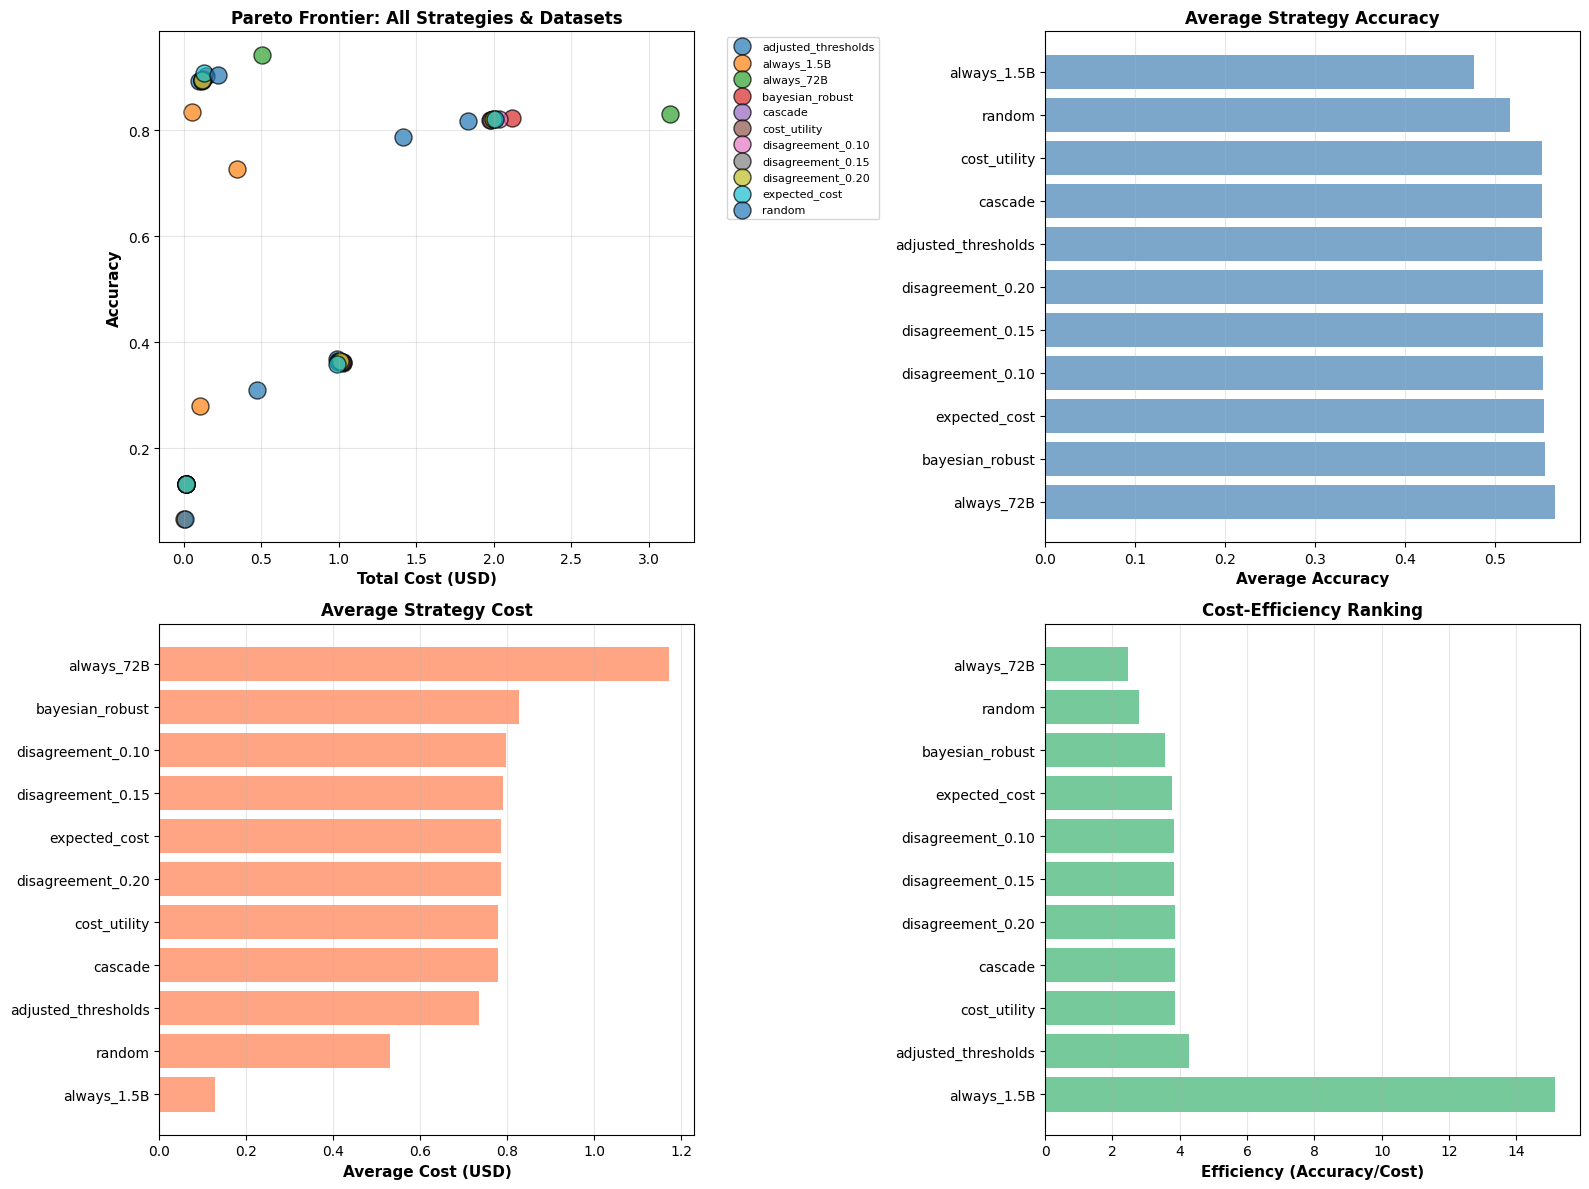


STRATEGY RANKINGS

Best Accuracy:
  always_72B                     (openai_gsm8k                  ): 0.9424

Lowest Cost:
  always_1.5B                    (opencompass_AIME2025          ): $0.0016

Best Efficiency (Accuracy/Cost):
  always_1.5B                    (opencompass_AIME2025          ): 40.937468


In [79]:
# === STRATEGY PARETO FRONTIER ANALYSIS ===
# Visualize cost-accuracy tradeoffs for all strategies

if not strategy_results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall Pareto Frontier (all datasets)
    ax1 = axes[0, 0]
    for strategy in strategy_results_df['strategy'].unique():
        strategy_data = strategy_results_df[strategy_results_df['strategy'] == strategy]
        ax1.scatter(strategy_data['cost'], strategy_data['accuracy'], 
                   label=strategy, s=150, alpha=0.7, edgecolor='black', linewidth=1)
    
    ax1.set_xlabel('Total Cost (USD)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Pareto Frontier: All Strategies & Datasets', fontsize=12, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Strategy Performance (avg across datasets)
    ax2 = axes[0, 1]
    strategy_avg = strategy_results_df.groupby('strategy')[['accuracy', 'cost']].mean()
    strategy_avg = strategy_avg.sort_values('accuracy', ascending=False)
    
    ax2.barh(range(len(strategy_avg)), strategy_avg['accuracy'].values, color='steelblue', alpha=0.7)
    ax2.set_yticks(range(len(strategy_avg)))
    ax2.set_yticklabels(strategy_avg.index)
    ax2.set_xlabel('Average Accuracy', fontsize=11, fontweight='bold')
    ax2.set_title('Average Strategy Accuracy', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Cost Comparison
    ax3 = axes[1, 0]
    strategy_cost = strategy_results_df.groupby('strategy')['cost'].mean().sort_values()
    
    ax3.barh(range(len(strategy_cost)), strategy_cost.values, color='coral', alpha=0.7)
    ax3.set_yticks(range(len(strategy_cost)))
    ax3.set_yticklabels(strategy_cost.index)
    ax3.set_xlabel('Average Cost (USD)', fontsize=11, fontweight='bold')
    ax3.set_title('Average Strategy Cost', fontsize=12, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Cost-Efficiency Score
    ax4 = axes[1, 1]
    strategy_results_df['efficiency'] = strategy_results_df['accuracy'] / (strategy_results_df['cost'] + 1e-6)
    efficiency_avg = strategy_results_df.groupby('strategy')['efficiency'].mean().sort_values(ascending=False)
    
    ax4.barh(range(len(efficiency_avg)), efficiency_avg.values, color='mediumseagreen', alpha=0.7)
    ax4.set_yticks(range(len(efficiency_avg)))
    ax4.set_yticklabels(efficiency_avg.index)
    ax4.set_xlabel('Efficiency (Accuracy/Cost)', fontsize=11, fontweight='bold')
    ax4.set_title('Cost-Efficiency Ranking', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("STRATEGY RANKINGS")
    print("=" * 80)
    
    print("\nBest Accuracy:")
    best_acc_idx = strategy_results_df['accuracy'].idxmax()
    best_acc = strategy_results_df.loc[best_acc_idx]
    print(f"  {best_acc['strategy']:30s} ({best_acc['dataset']:30s}): {best_acc['accuracy']:.4f}")
    
    print("\nLowest Cost:")
    lowest_cost_idx = strategy_results_df['cost'].idxmin()
    lowest_cost = strategy_results_df.loc[lowest_cost_idx]
    print(f"  {lowest_cost['strategy']:30s} ({lowest_cost['dataset']:30s}): ${lowest_cost['cost']:.4f}")
    
    print("\nBest Efficiency (Accuracy/Cost):")
    efficiency_max_idx = strategy_results_df['efficiency'].idxmax()
    best_eff = strategy_results_df.loc[efficiency_max_idx]
    print(f"  {best_eff['strategy']:30s} ({best_eff['dataset']:30s}): {best_eff['efficiency']:.6f}")


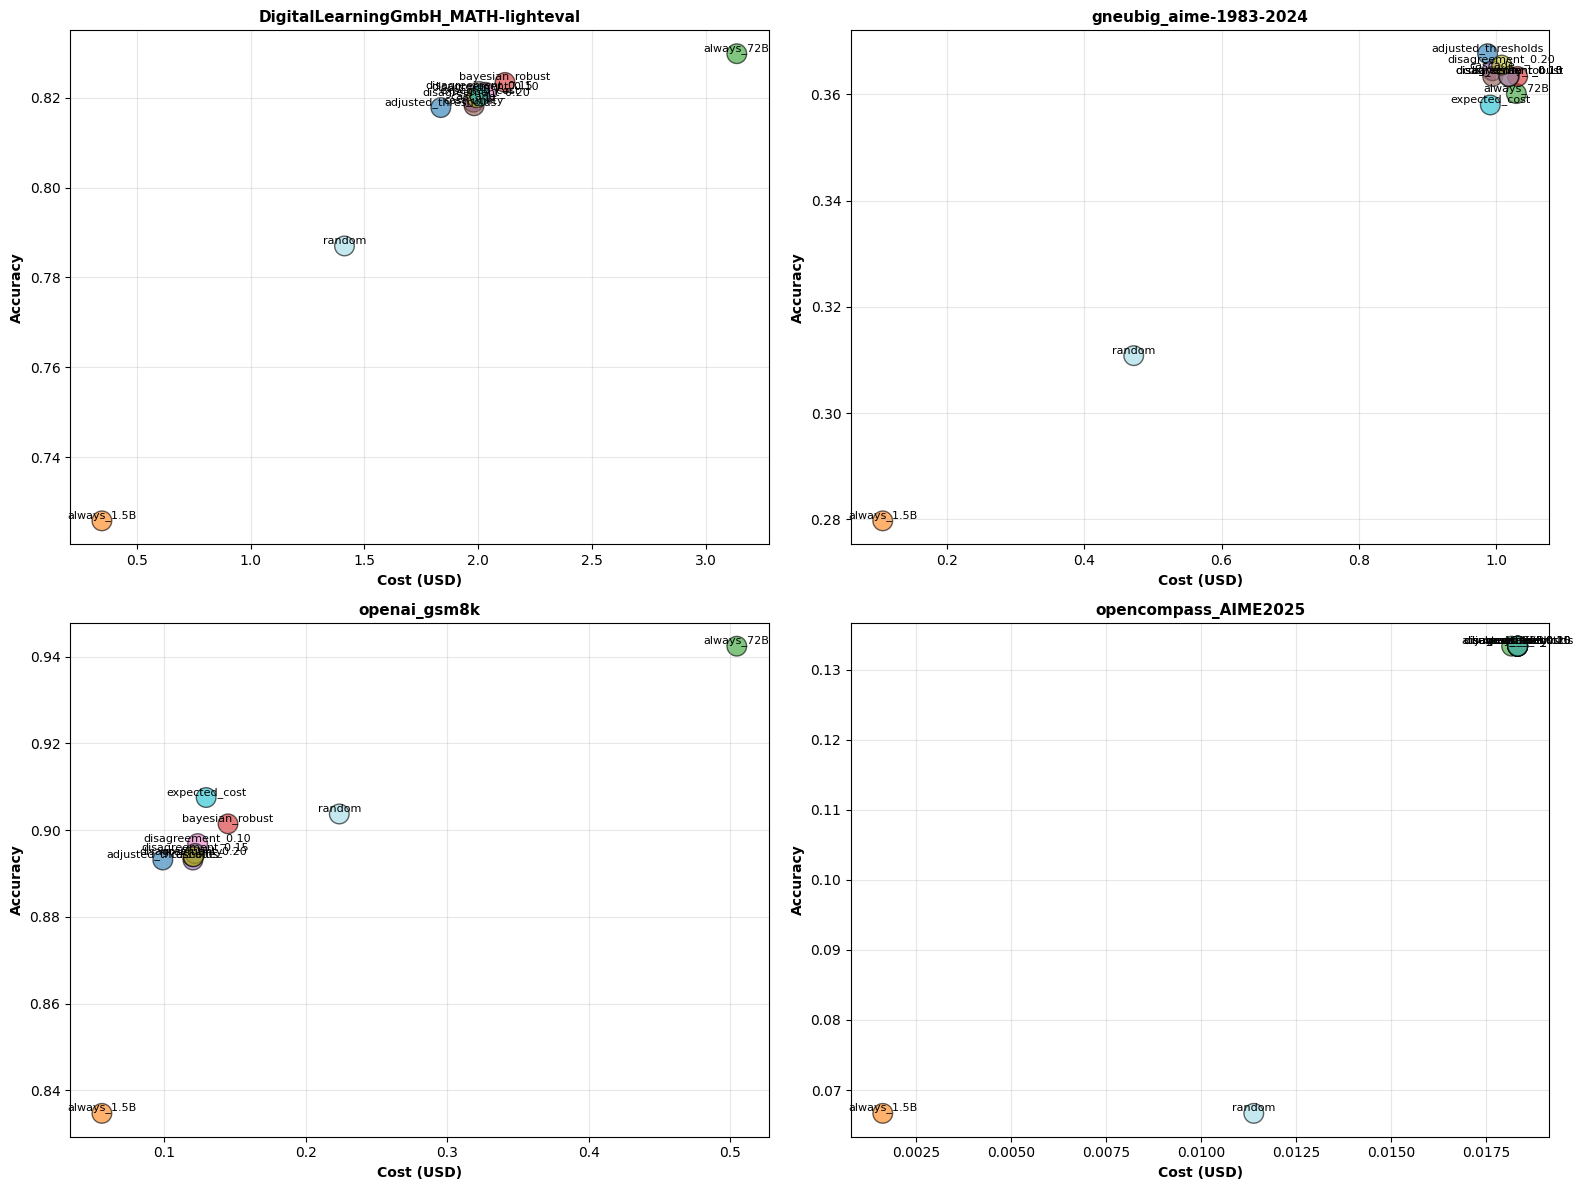


DATASET-SPECIFIC STRATEGY PERFORMANCE

DIGITALLEARNINGGMBH_MATH-LIGHTEVAL:
Strategy                            Accuracy     Cost         Efficiency  
-----------------------------------------------------------------------
always_72B                          0.8298       $3.1375     0.264475
bayesian_robust                     0.8234       $2.1180     0.388771
disagreement_0.15                   0.8214       $2.0042     0.409842
disagreement_0.10                   0.8212       $2.0330     0.403941
expected_cost                       0.8204       $2.0074     0.408695
disagreement_0.20                   0.8200       $1.9929     0.411458
cascade                             0.8190       $1.9793     0.413788
cost_utility                        0.8182       $1.9820     0.412825
adjusted_thresholds                 0.8178       $1.8357     0.445502
random                              0.7870       $1.4120     0.557365
always_1.5B                         0.7258       $0.3450     2.103468

GNEUBI

In [80]:
# === DATASET-SPECIFIC STRATEGY COMPARISON ===

if not strategy_results_df.empty:
    datasets = sorted(strategy_results_df['dataset'].unique())
    n_datasets = len(datasets)
    
    # Create subplots for each dataset
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):
        if idx >= 4:  # Max 4 subplots
            break
        
        ax = axes[idx]
        dataset_data = strategy_results_df[strategy_results_df['dataset'] == dataset]
        
        # Scatter plot: cost vs accuracy for this dataset
        strategies = dataset_data['strategy'].values
        costs = dataset_data['cost'].values
        accuracies = dataset_data['accuracy'].values
        
        scatter = ax.scatter(costs, accuracies, s=200, alpha=0.6, c=range(len(strategies)), 
                           cmap='tab20', edgecolor='black', linewidth=1)
        
        # Annotate points with strategy names
        for i, strategy in enumerate(strategies):
            ax.annotate(strategy, (costs[i], accuracies[i]), 
                       fontsize=8, ha='center', va='bottom')
        
        ax.set_xlabel('Cost (USD)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
        ax.set_title(f'{dataset}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(datasets), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed dataset comparisons
    print("\n" + "=" * 80)
    print("DATASET-SPECIFIC STRATEGY PERFORMANCE")
    print("=" * 80)
    
    for dataset in datasets:
        dataset_data = strategy_results_df[strategy_results_df['dataset'] == dataset].copy()
        dataset_data = dataset_data.sort_values('accuracy', ascending=False)
        
        print(f"\n{dataset.upper()}:")
        print(f"{'Strategy':<35} {'Accuracy':<12} {'Cost':<12} {'Efficiency':<12}")
        print("-" * 71)
        
        for _, row in dataset_data.iterrows():
            eff = row['accuracy'] / (row['cost'] + 1e-6)
            print(f"{row['strategy']:<35} {row['accuracy']:.4f}       ${row['cost']:<10.4f} {eff:.6f}")


In [71]:
# === ROUTING DECISION BREAKDOWN ===
# Analyze how each router allocates questions to different models

print("\n" + "="*80)
print("ROUTING ALLOCATION ANALYSIS")
print("="*80)

routing_allocations = []

for dataset in strategy_results_df['dataset'].unique():
    try:
        # Load cascade results for this dataset
        cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{dataset}_routed/answered_cascade.parquet"
        cascade_df = pd.read_parquet(cascade_path)
        
        route_counts = cascade_df['route_to'].value_counts()
        total = len(cascade_df)
        
        print(f"\n{dataset.upper()} - CASCADE ROUTER:")
        print(f"{'Model':<50} {'Count':<8} {'Percentage':<12}")
        print("-" * 70)
        
        for model, count in route_counts.items():
            pct = 100 * count / total
            # Get cost ratio
            if "1.5B" in model:
                cost_ratio = 1.0
            elif "7B" in model:
                cost_ratio = 2.0
            else:
                cost_ratio = 9.0
            print(f"{model:<50} {count:<8} {pct:>6.1f}% (cost: {cost_ratio:.1f}x)")
        
        avg_cost = sum((route_counts.get(model, 0) / total) * 
                      (1.0 if "1.5B" in model else (2.0 if "7B" in model else 9.0))
                      for model in route_counts.index)
        print(f"\nAverage Cost Multiplier: {avg_cost:.2f}x")
        
    except Exception as e:
        print(f"Could not load routing data for {dataset}: {e}")

print("\n" + "="*80)



ROUTING ALLOCATION ANALYSIS

DIGITALLEARNINGGMBH_MATH-LIGHTEVAL - CASCADE ROUTER:
Model                                              Count    Percentage  
----------------------------------------------------------------------
Qwen/Qwen2.5-Math-1.5B-Instruct                    2506       50.1% (cost: 1.0x)
Qwen/Qwen2.5-Math-72B-Instruct                     2174       43.5% (cost: 9.0x)
Qwen/Qwen2.5-Math-7B-Instruct                      320         6.4% (cost: 2.0x)

Average Cost Multiplier: 4.54x

GNEUBIG_AIME-1983-2024 - CASCADE ROUTER:
Model                                              Count    Percentage  
----------------------------------------------------------------------
Qwen/Qwen2.5-Math-72B-Instruct                     898        96.2% (cost: 9.0x)
Qwen/Qwen2.5-Math-1.5B-Instruct                    31          3.3% (cost: 1.0x)
Qwen/Qwen2.5-Math-7B-Instruct                      4           0.4% (cost: 2.0x)

Average Cost Multiplier: 8.70x

OPENAI_GSM8K - CASCADE ROUTER:
Model

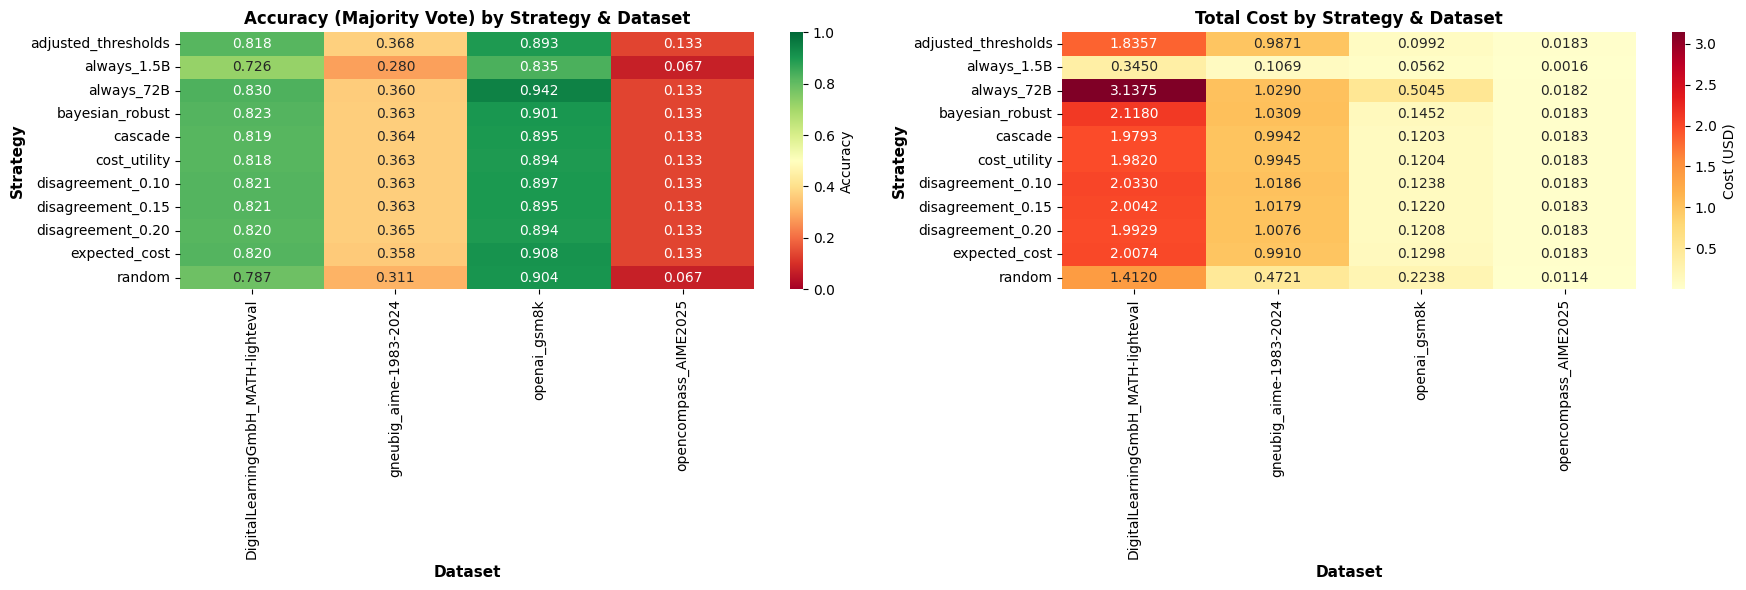


HEATMAP INSIGHTS

Best Accuracy:
  Strategy: always_72B
  Dataset: openai_gsm8k
  Accuracy: 0.9424

Lowest Cost:
  Strategy: always_1.5B
  Dataset: opencompass_AIME2025
  Cost: $0.0016

Highest Efficiency (Accuracy/Cost):
  Strategy: always_1.5B
  Dataset: opencompass_AIME2025
  Efficiency: 40.937468



In [72]:
# === DETAILED ROUTER COMPARISON MATRIX ===
# Create heatmaps showing performance across datasets

import seaborn as sns

if not strategy_results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Prepare pivot tables - use 'strategy' instead of 'router'
    accuracy_pivot = strategy_results_df.pivot_table(values='accuracy', index='strategy', columns='dataset')
    cost_pivot = strategy_results_df.pivot_table(values='cost', index='strategy', columns='dataset')
    
    # Calculate efficiency for heatmap
    strategy_results_df['efficiency'] = strategy_results_df['accuracy'] / (strategy_results_df['cost'] + 1e-6)
    efficiency_pivot = strategy_results_df.pivot_table(values='efficiency', index='strategy', columns='dataset')
    
    # 1. Accuracy Heatmap
    sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], 
                cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
    axes[0].set_title('Accuracy (Majority Vote) by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    # 2. Cost Heatmap
    sns.heatmap(cost_pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1],
                cbar_kws={'label': 'Cost (USD)'})
    axes[1].set_title('Total Cost by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("HEATMAP INSIGHTS")
    print("="*80)
    
    # Find best performers
    print("\nBest Accuracy:")
    best_acc = strategy_results_df.loc[strategy_results_df['accuracy'].idxmax()]
    print(f"  Strategy: {best_acc['strategy']}")
    print(f"  Dataset: {best_acc['dataset']}")
    print(f"  Accuracy: {best_acc['accuracy']:.4f}")
    
    print("\nLowest Cost:")
    lowest_cost = strategy_results_df.loc[strategy_results_df['cost'].idxmin()]
    print(f"  Strategy: {lowest_cost['strategy']}")
    print(f"  Dataset: {lowest_cost['dataset']}")
    print(f"  Cost: ${lowest_cost['cost']:.4f}")
    
    print("\nHighest Efficiency (Accuracy/Cost):")
    best_efficiency = strategy_results_df.loc[strategy_results_df['efficiency'].idxmax()]
    print(f"  Strategy: {best_efficiency['strategy']}")
    print(f"  Dataset: {best_efficiency['dataset']}")
    print(f"  Efficiency: {best_efficiency['efficiency']:.6f}")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")

In [73]:
# === STRATEGY RANKING & STATISTICAL ANALYSIS ===

from scipy import stats

if not strategy_results_df.empty:
    print("\n" + "="*80)
    print("STRATEGY STATISTICAL COMPARISON")
    print("="*80)
    
    # Group comparisons by metric
    metrics = ['accuracy', 'passk', 'cost', 'efficiency']
    
    for metric in metrics:
        print(f"\n{metric.upper()} RANKING:")
        print("-" * 80)
        
        if metric == 'cost':
            # For cost, lower is better
            ranking = strategy_results_df.groupby('strategy')[metric].mean().sort_values()
        else:
            # For others, higher is better
            ranking = strategy_results_df.groupby('strategy')[metric].mean().sort_values(ascending=False)
        
        for i, (strategy, value) in enumerate(ranking.items(), 1):
            if metric == 'cost':
                print(f"{i}. {strategy:<50} ${value:.4f}")
            elif metric == 'efficiency':
                print(f"{i}. {strategy:<50} {value:.6f} (acc/cost)")
            else:
                print(f"{i}. {strategy:<50} {value:.4f}")
    
    # Compare average strategy performance
    print("\n" + "-"*80)
    print("SUMMARY STATISTICS")
    print("-"*80)
    print(f"Total strategies evaluated: {strategy_results_df['strategy'].nunique()}")
    print(f"Total datasets: {strategy_results_df['dataset'].nunique()}")
    print(f"Total result points: {len(strategy_results_df)}")
    print(f"\nStrategies:")
    for strategy in sorted(strategy_results_df['strategy'].unique()):
        count = len(strategy_results_df[strategy_results_df['strategy'] == strategy])
        avg_acc = strategy_results_df[strategy_results_df['strategy'] == strategy]['accuracy'].mean()
        avg_cost = strategy_results_df[strategy_results_df['strategy'] == strategy]['cost'].mean()
        print(f"  - {strategy:<35} {count} datasets | Avg Acc: {avg_acc:.4f} | Avg Cost: ${avg_cost:.4f}")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")


STRATEGY STATISTICAL COMPARISON

ACCURACY RANKING:
--------------------------------------------------------------------------------
1. always_72B                                         0.5664
2. bayesian_robust                                    0.5554
3. expected_cost                                      0.5548
4. disagreement_0.10                                  0.5537
5. disagreement_0.15                                  0.5532
6. disagreement_0.20                                  0.5532
7. adjusted_thresholds                                0.5530
8. cascade                                            0.5528
9. cost_utility                                       0.5522
10. random                                             0.5171
11. always_1.5B                                        0.4767

PASSK RANKING:
--------------------------------------------------------------------------------
1. always_72B                                         0.5664
2. bayesian_robust                  


ROUTING ALLOCATION ACROSS STRATEGIES

DIGITALLEARNINGGMBH_MATH-LIGHTEVAL:
--------------------------------------------------------------------------------

  adjusted_thresholds:
    1.5B    2506 ( 50.1%) - cost: 1.0x
    72B     1887 ( 37.7%) - cost: 9.0x
    7B       607 ( 12.1%) - cost: 2.0x
    Avg Cost Multiplier: 4.14x

  always_1.5B:
    1.5B    5000 (100.0%) - cost: 1.0x
    Avg Cost Multiplier: 1.00x

  always_72B:
    72B     5000 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  bayesian_robust:
    72B     2459 ( 49.2%) - cost: 9.0x
    1.5B    2221 ( 44.4%) - cost: 1.0x
    7B       320 (  6.4%) - cost: 2.0x
    Avg Cost Multiplier: 5.00x

  cascade:
    1.5B    2506 ( 50.1%) - cost: 1.0x
    72B     2174 ( 43.5%) - cost: 9.0x
    7B       320 (  6.4%) - cost: 2.0x
    Avg Cost Multiplier: 4.54x

  cost_utility:
    1.5B    2506 ( 50.1%) - cost: 1.0x
    72B     2174 ( 43.5%) - cost: 9.0x
    7B       320 (  6.4%) - cost: 2.0x
    Avg Cost Multiplier: 4.54x


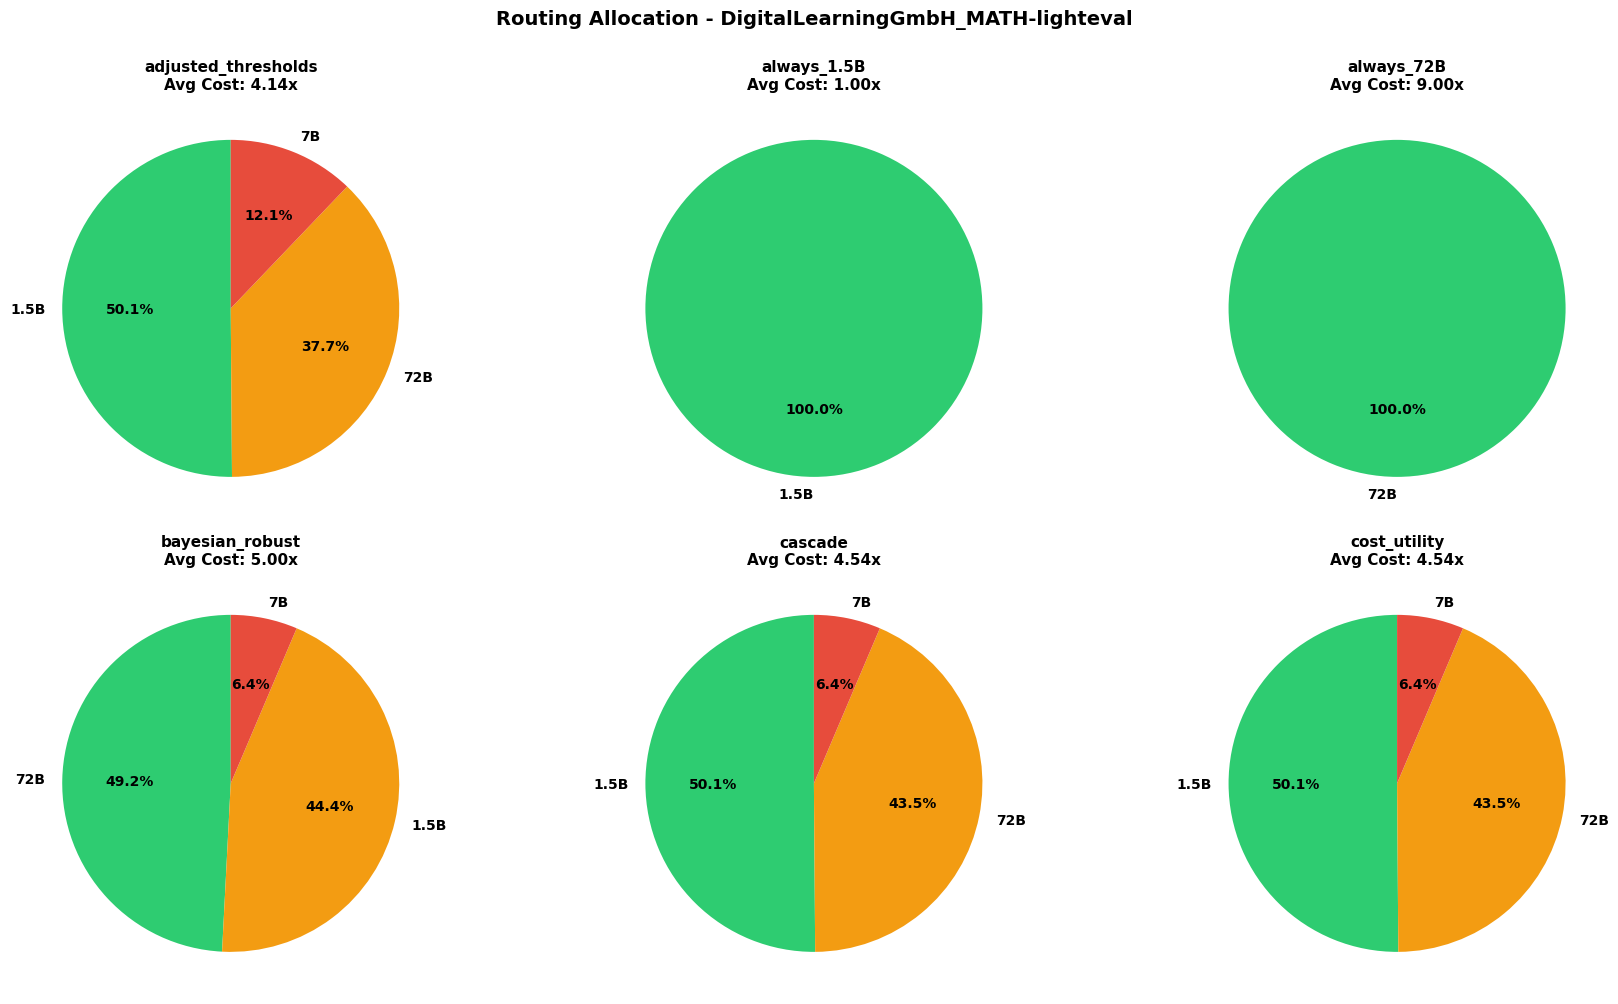


GNEUBIG_AIME-1983-2024:
--------------------------------------------------------------------------------

  adjusted_thresholds:
    72B      887 ( 95.1%) - cost: 9.0x
    1.5B      31 (  3.3%) - cost: 1.0x
    7B        15 (  1.6%) - cost: 2.0x
    Avg Cost Multiplier: 8.62x

  always_1.5B:
    1.5B     933 (100.0%) - cost: 1.0x
    Avg Cost Multiplier: 1.00x

  always_72B:
    72B      933 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  bayesian_robust:
    72B      921 ( 98.7%) - cost: 9.0x
    1.5B       8 (  0.9%) - cost: 1.0x
    7B         4 (  0.4%) - cost: 2.0x
    Avg Cost Multiplier: 8.90x

  cascade:
    72B      898 ( 96.2%) - cost: 9.0x
    1.5B      31 (  3.3%) - cost: 1.0x
    7B         4 (  0.4%) - cost: 2.0x
    Avg Cost Multiplier: 8.70x

  cost_utility:
    72B      898 ( 96.2%) - cost: 9.0x
    1.5B      31 (  3.3%) - cost: 1.0x
    7B         4 (  0.4%) - cost: 2.0x
    Avg Cost Multiplier: 8.70x


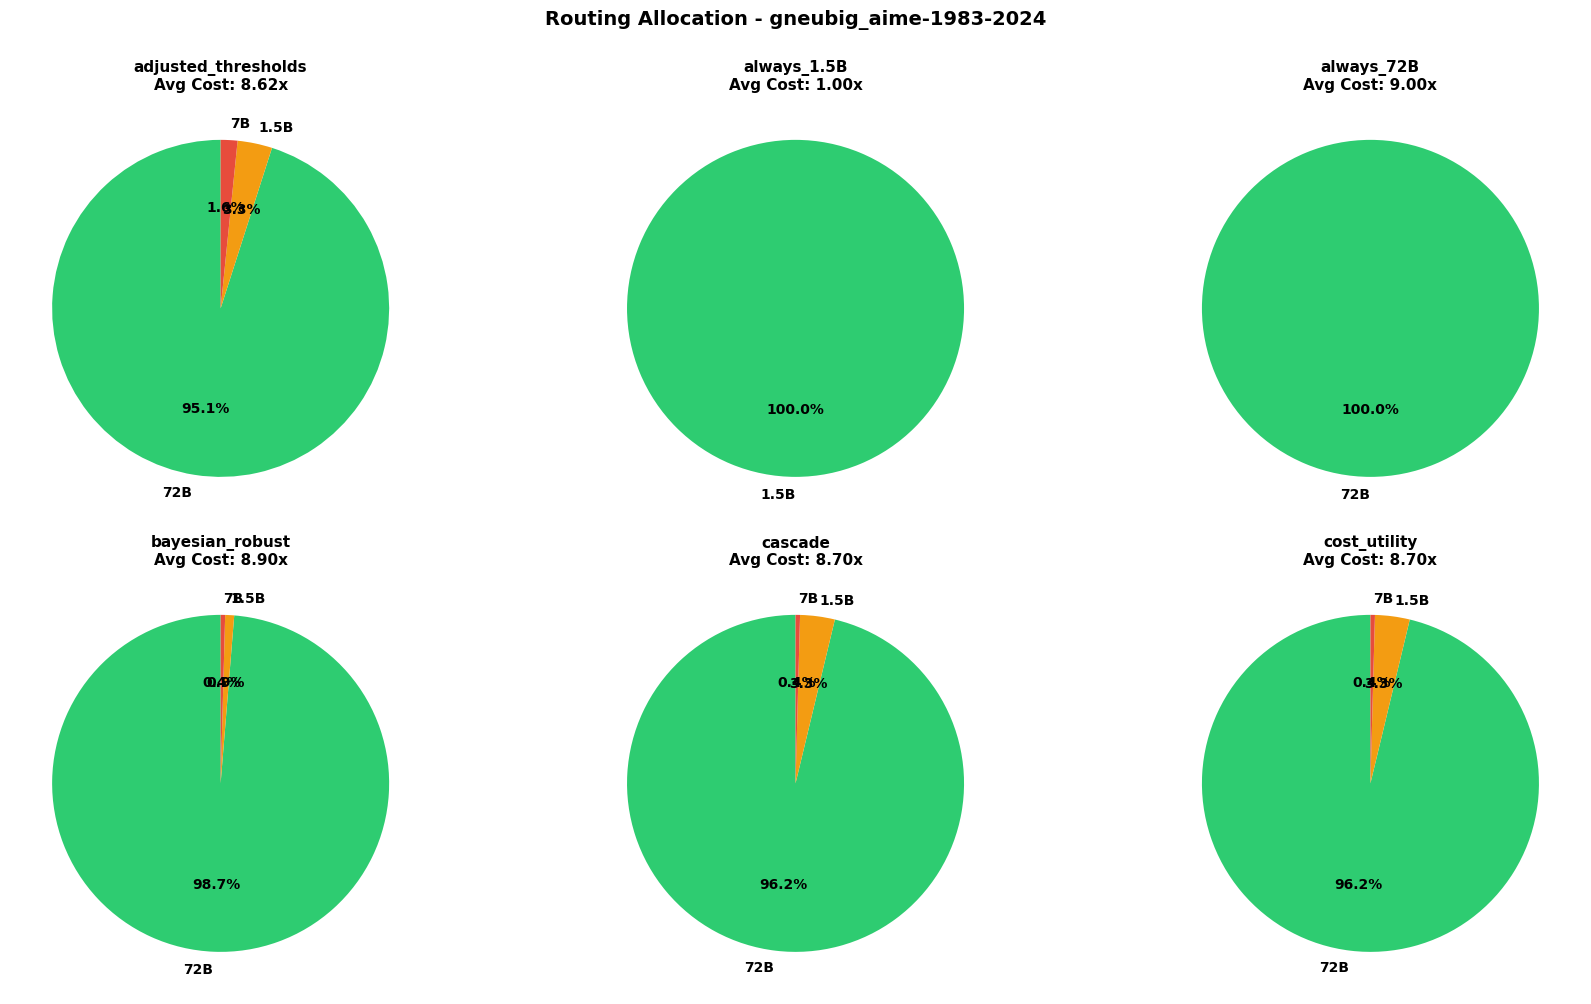


OPENAI_GSM8K:
--------------------------------------------------------------------------------

  adjusted_thresholds:
    1.5B    1012 ( 76.7%) - cost: 1.0x
    7B       231 ( 17.5%) - cost: 2.0x
    72B       76 (  5.8%) - cost: 9.0x
    Avg Cost Multiplier: 1.64x

  always_1.5B:
    1.5B    1319 (100.0%) - cost: 1.0x
    Avg Cost Multiplier: 1.00x

  always_72B:
    72B     1319 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  bayesian_robust:
    1.5B     953 ( 72.3%) - cost: 1.0x
    72B      199 ( 15.1%) - cost: 9.0x
    7B       167 ( 12.7%) - cost: 2.0x
    Avg Cost Multiplier: 2.33x

  cascade:
    1.5B    1012 ( 76.7%) - cost: 1.0x
    7B       167 ( 12.7%) - cost: 2.0x
    72B      140 ( 10.6%) - cost: 9.0x
    Avg Cost Multiplier: 1.98x

  cost_utility:
    1.5B    1012 ( 76.7%) - cost: 1.0x
    7B       167 ( 12.7%) - cost: 2.0x
    72B      140 ( 10.6%) - cost: 9.0x
    Avg Cost Multiplier: 1.98x


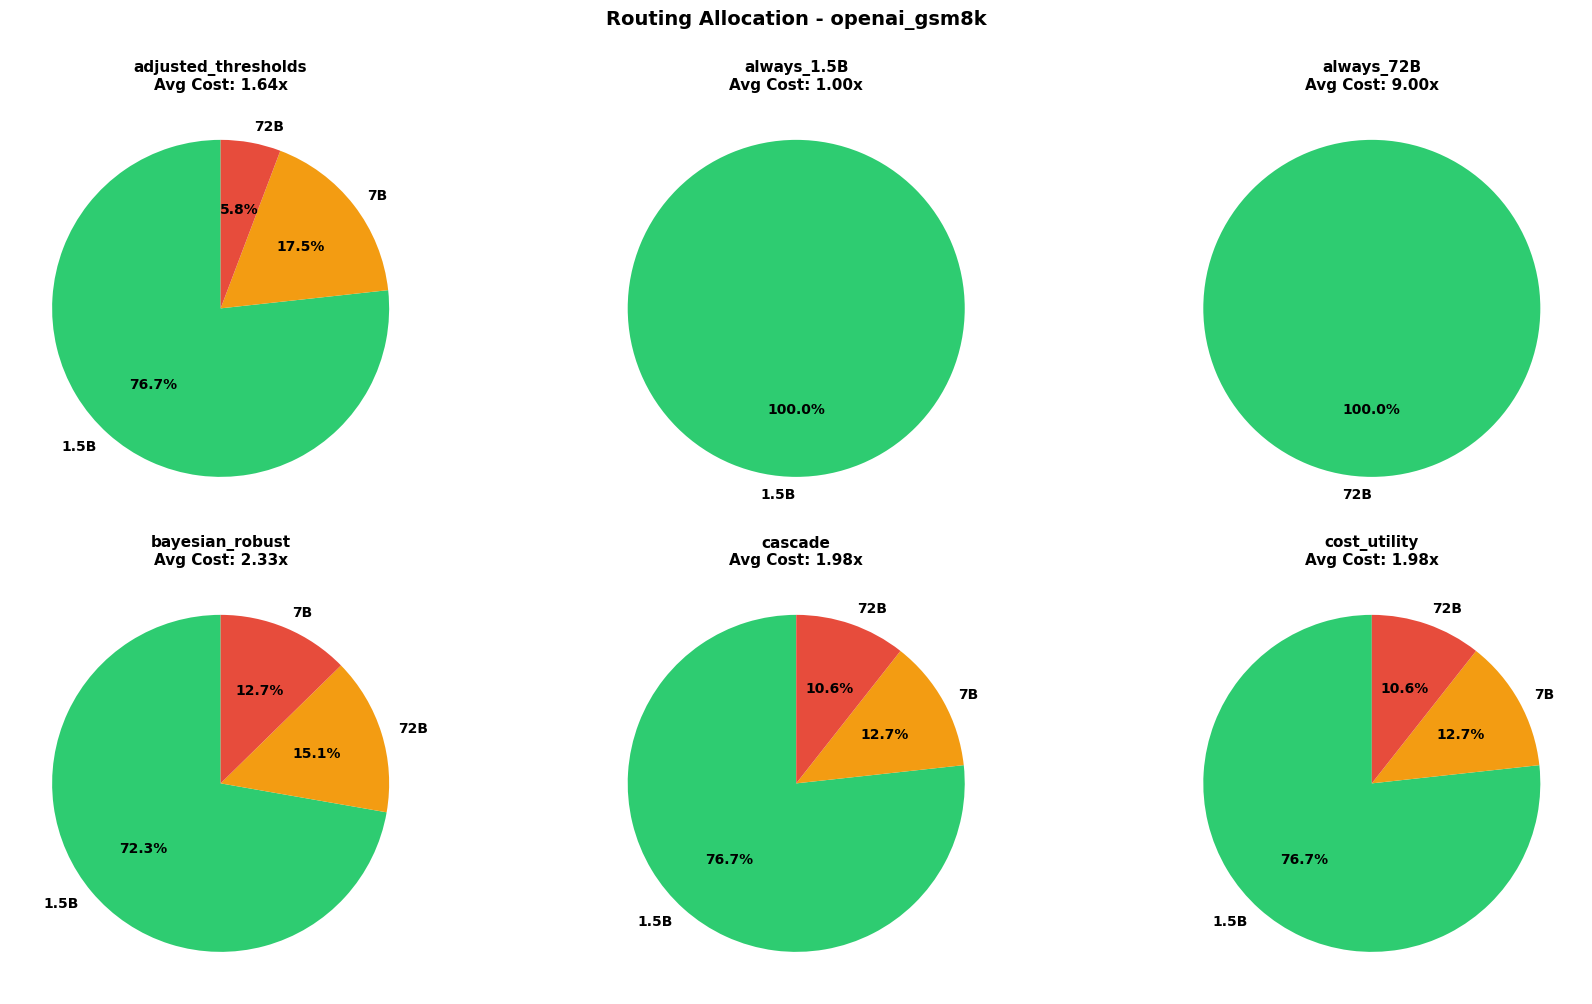


OPENCOMPASS_AIME2025:
--------------------------------------------------------------------------------

  adjusted_thresholds:
    72B       15 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  always_1.5B:
    1.5B      15 (100.0%) - cost: 1.0x
    Avg Cost Multiplier: 1.00x

  always_72B:
    72B       15 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  bayesian_robust:
    72B       15 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  cascade:
    72B       15 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x

  cost_utility:
    72B       15 (100.0%) - cost: 9.0x
    Avg Cost Multiplier: 9.00x


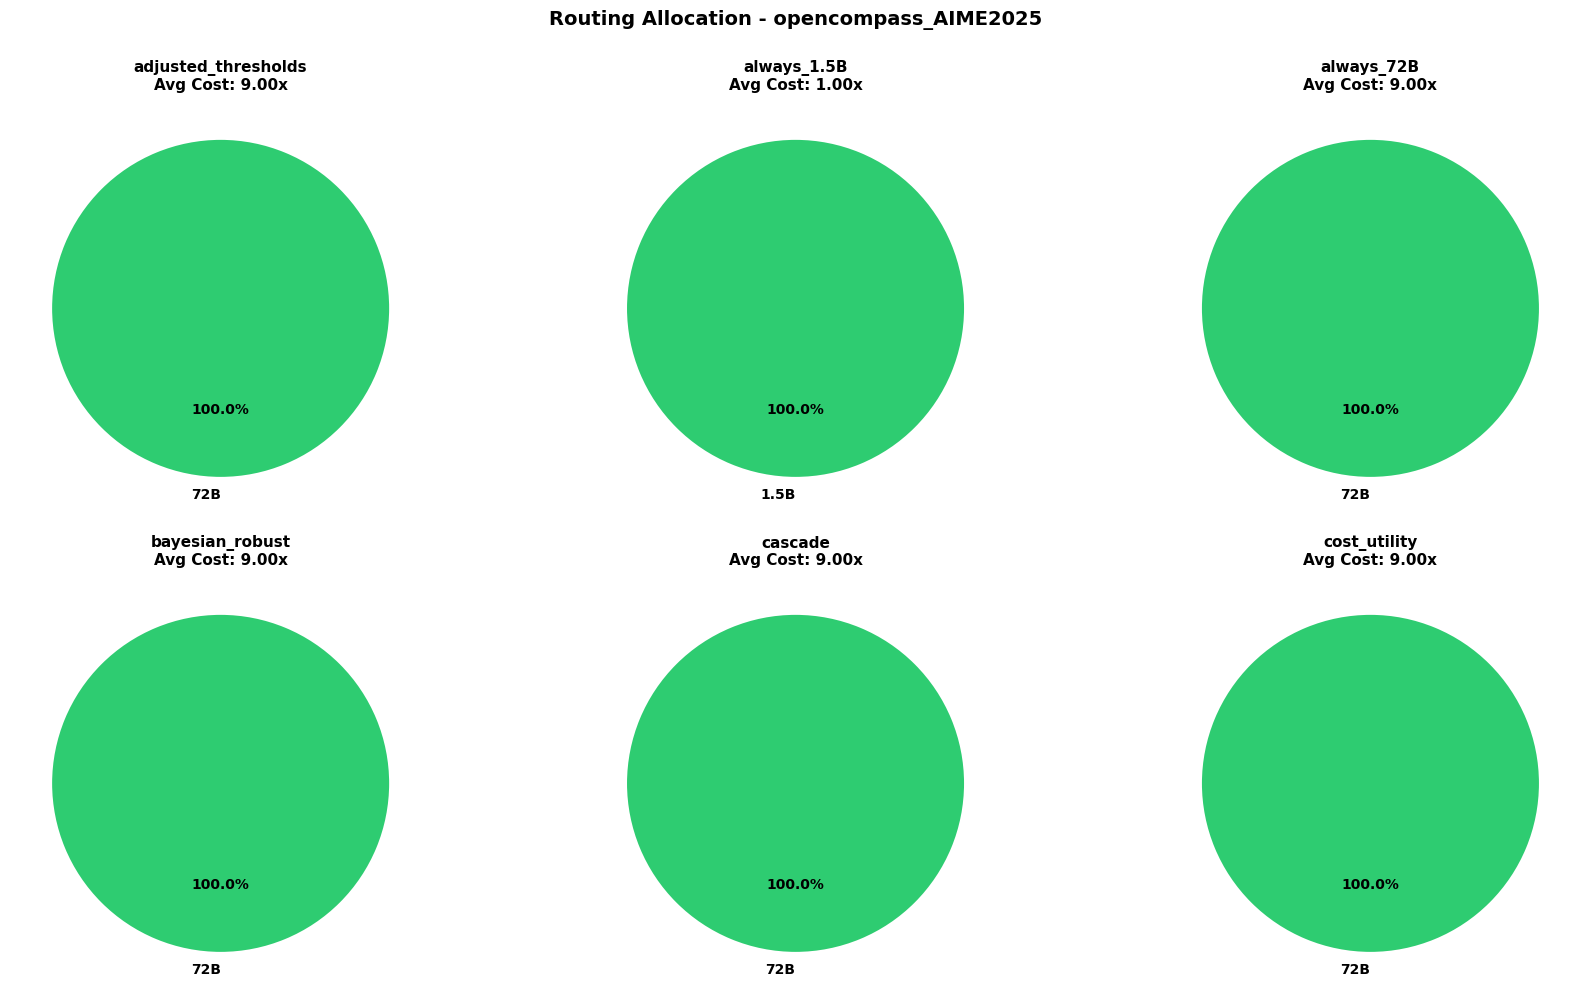


ALLOCATION SUMMARY - AVERAGE COST MULTIPLIER BY STRATEGY

Strategy                            Avg Cost Mult        Min        Max       
---------------------------------------------------------------------------
adjusted_thresholds                 5.85                x 1.64      x 9.00      x
always_1.5B                         1.00                x 1.00      x 1.00      x
always_72B                          9.00                x 9.00      x 9.00      x
bayesian_robust                     6.31                x 2.33      x 9.00      x
cascade                             6.06                x 1.98      x 9.00      x
cost_utility                        6.06                x 1.98      x 9.00      x
disagreement_0.10                   6.15                x 2.03      x 9.00      x
disagreement_0.15                   6.11                x 2.00      x 9.00      x
disagreement_0.20                   6.08                x 1.98      x 9.00      x
expected_cost                       6.13        

In [74]:
# === ROUTING ALLOCATION VISUALIZATION ===
# Visualize how each strategy allocates questions to different models

if not strategy_results_df.empty:
    print("\n" + "="*80)
    print("ROUTING ALLOCATION ACROSS STRATEGIES")
    print("="*80)
    
    datasets = sorted(strategy_results_df['dataset'].unique())
    strategies = sorted(strategy_results_df['strategy'].unique())
    
    # Base path (same as used in loading results)
    RESULTS_BASE_DIR = "../../pika_cascade_trial"
    PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
    
    # For each dataset, create a visualization
    for dataset in datasets:
        print(f"\n{dataset.upper()}:")
        print("-" * 80)
        
        # Create figure for this dataset
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        dataset_strategies = strategy_results_df[strategy_results_df['dataset'] == dataset]['strategy'].unique()
        
        allocation_data = []
        
        for idx, strategy in enumerate(sorted(dataset_strategies)):
            if idx >= 6:  # Max 6 subplots per dataset
                break
            
            try:
                # Load the routing results for this strategy and dataset
                strategy_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_{strategy}_conf0.9.parquet"
                strategy_df = pd.read_parquet(strategy_path)
                
                # Get routing counts
                route_counts = strategy_df['route_to'].value_counts()
                total = len(strategy_df)
                
                # Extract model info
                models = []
                counts = []
                percentages = []
                costs = []
                
                for model, count in route_counts.items():
                    pct = 100 * count / total
                    if "1.5B" in model:
                        cost_ratio = 1.0
                        model_name = "1.5B"
                    elif "7B" in model:
                        cost_ratio = 2.0
                        model_name = "7B"
                    else:
                        cost_ratio = 9.0
                        model_name = "72B"
                    
                    models.append(model_name)
                    counts.append(count)
                    percentages.append(pct)
                    costs.append(cost_ratio)
                
                # Plot pie chart
                ax = axes[idx]
                colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
                wedges, texts, autotexts = ax.pie(percentages, labels=models, autopct='%1.1f%%',
                                                    colors=colors[:len(models)], startangle=90,
                                                    textprops={'fontsize': 10, 'weight': 'bold'})
                
                # Add title with strategy and cost info
                avg_cost = sum((c / total) * r for c, r in zip(counts, costs))
                ax.set_title(f'{strategy}\nAvg Cost: {avg_cost:.2f}x', 
                            fontsize=11, fontweight='bold')
                
                # Print text summary
                print(f"\n  {strategy}:")
                for model, count, pct, cost in zip(models, counts, percentages, costs):
                    print(f"    {model:<6} {count:>5} ({pct:>5.1f}%) - cost: {cost:.1f}x")
                print(f"    Avg Cost Multiplier: {avg_cost:.2f}x")
                
                allocation_data.append({
                    'dataset': dataset,
                    'strategy': strategy,
                    'avg_cost_multiplier': avg_cost,
                    '1.5B': route_counts.get([m for m in route_counts.index if '1.5B' in m][0], 0) / total if any('1.5B' in m for m in route_counts.index) else 0,
                    '7B': route_counts.get([m for m in route_counts.index if '7B' in m][0], 0) / total if any('7B' in m for m in route_counts.index) else 0,
                    '72B': route_counts.get([m for m in route_counts.index if '72B' in m][0], 0) / total if any('72B' in m for m in route_counts.index) else 0,
                })
                
            except FileNotFoundError as e:
                print(f"  {strategy}: File not found at {strategy_path}")
                ax = axes[idx]
                ax.text(0.5, 0.5, f'{strategy}\n(Not Ready)', 
                       ha='center', va='center', fontsize=12, color='gray',
                       transform=ax.transAxes)
                ax.axis('off')
            except Exception as e:
                print(f"  {strategy}: Error - {e}")
                ax = axes[idx]
                ax.axis('off')
        
        # Hide unused subplots
        for idx in range(len(sorted(dataset_strategies)), 6):
            axes[idx].axis('off')
        
        plt.suptitle(f'Routing Allocation - {dataset}', fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()
    
    # Create summary table comparing allocations
    print("\n" + "="*80)
    print("ALLOCATION SUMMARY - AVERAGE COST MULTIPLIER BY STRATEGY")
    print("="*80)
    
    allocation_costs = {}
    
    for dataset in datasets:
        for strategy in strategies:
            try:
                strategy_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_{strategy}_conf0.9.parquet"
                strategy_df = pd.read_parquet(strategy_path)
                
                route_counts = strategy_df['route_to'].value_counts()
                total = len(strategy_df)
                
                avg_cost = 0
                for model, count in route_counts.items():
                    if "1.5B" in model:
                        cost_ratio = 1.0
                    elif "7B" in model:
                        cost_ratio = 2.0
                    else:
                        cost_ratio = 9.0
                    avg_cost += (count / total) * cost_ratio
                
                key = f"{strategy}"
                if key not in allocation_costs:
                    allocation_costs[key] = []
                allocation_costs[key].append(avg_cost)
            except:
                pass
    
    print(f"\n{'Strategy':<35} {'Avg Cost Mult':<20} {'Min':<10} {'Max':<10}")
    print("-" * 75)
    for strategy in sorted(allocation_costs.keys()):
        costs = allocation_costs[strategy]
        if costs:
            avg = sum(costs) / len(costs)
            print(f"{strategy:<35} {avg:<20.2f}x {min(costs):<10.2f}x {max(costs):<10.2f}x")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")


PHASE 1: THRESHOLD SWEEP ANALYSIS
✓ openai_gsm8k                        @ conf=0.9: Acc=0.8931 | Cost=$0.1204
✓ gneubig_aime-1983-2024              @ conf=0.9: Acc=0.3644 | Cost=$0.9942
✓ DigitalLearningGmbH_MATH-lighteval  @ conf=0.9: Acc=0.8190 | Cost=$1.9793
✓ opencompass_AIME2025                @ conf=0.9: Acc=0.1333 | Cost=$0.0183
✓ openai_gsm8k                        @ conf=0.85: Acc=0.8650 | Cost=$0.0864
✓ gneubig_aime-1983-2024              @ conf=0.85: Acc=0.3591 | Cost=$0.9713
✗ DigitalLearningGmbH_MATH-lighteval  @ conf=0.85: File not found
✓ opencompass_AIME2025                @ conf=0.85: Acc=0.1333 | Cost=$0.0183
✗ openai_gsm8k                        @ conf=0.8: File not found
✗ gneubig_aime-1983-2024              @ conf=0.8: File not found
✗ DigitalLearningGmbH_MATH-lighteval  @ conf=0.8: File not found
✗ opencompass_AIME2025                @ conf=0.8: File not found

THRESHOLD COMPARISON

DIGITALLEARNINGGMBH_MATH-LIGHTEVAL:
Threshold    Accuracy     Cost         1.5B% 

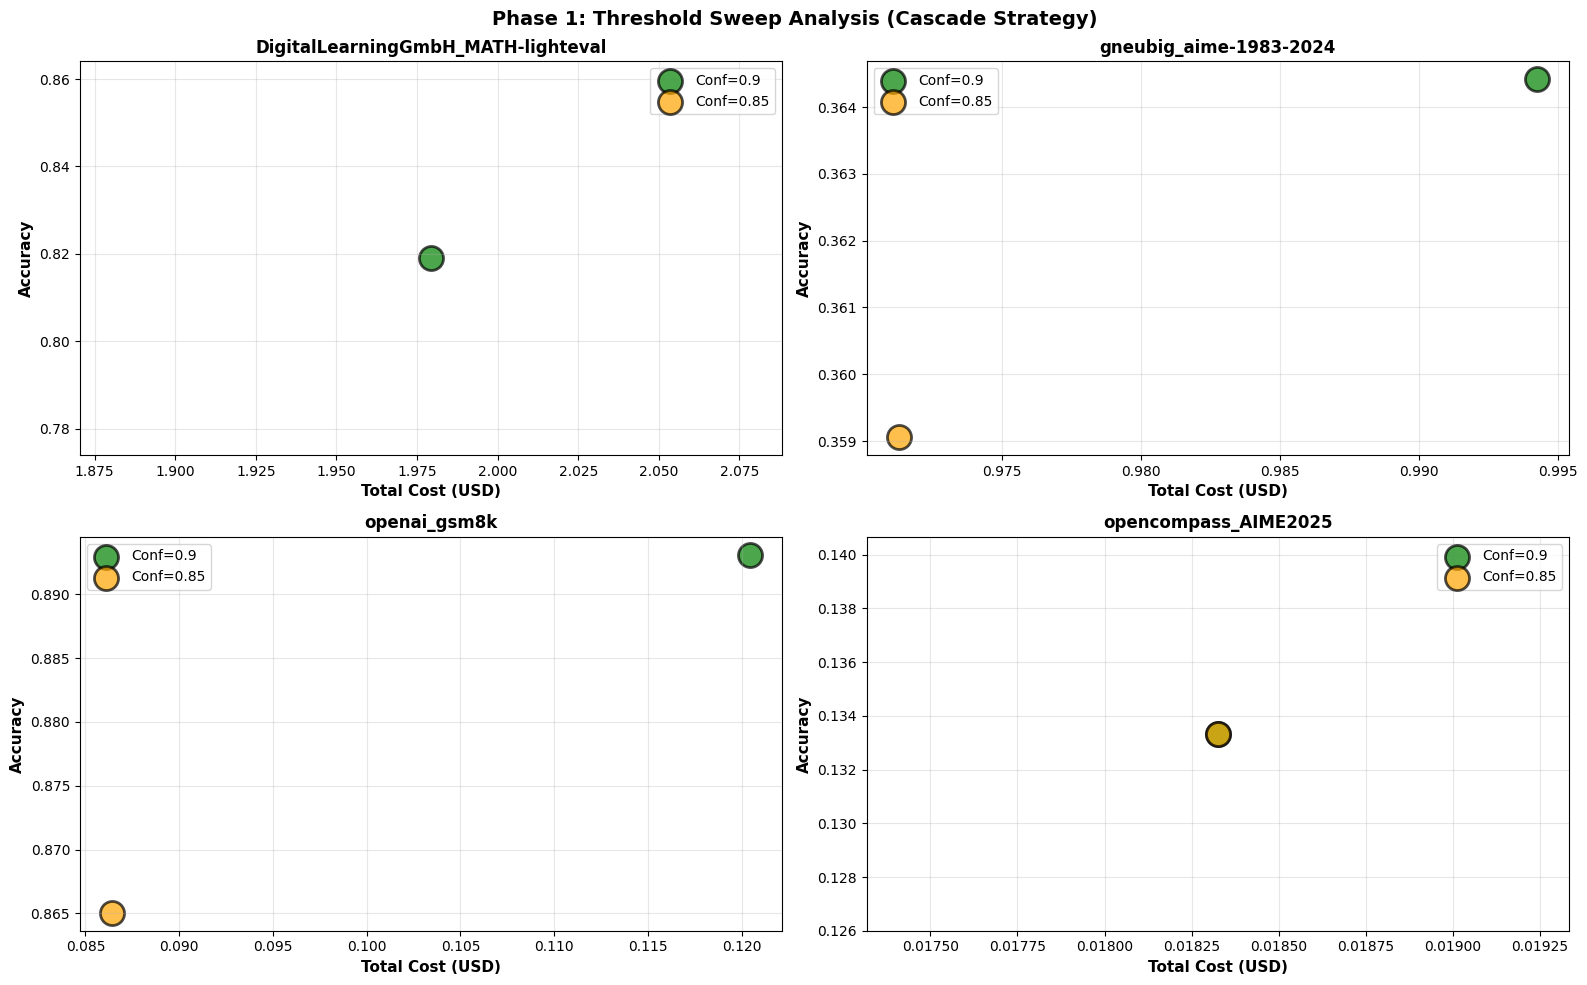


KEY FINDINGS - PHASE 1 THRESHOLD ANALYSIS

Accuracy Comparison (0.90 vs 0.85):

  gneubig_aime-1983-2024:
    Accuracy: 0.90=0.3644 vs 0.85=0.3591 📉 (-1.47%)
    Cost:     0.90=$0.9942 vs 0.85=$0.9713 💰 (-2.31%)
    Routing:  0.90: 72B=96.2% | 0.85: 72B=92.4%
    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓

  openai_gsm8k:
    Accuracy: 0.90=0.8931 vs 0.85=0.8650 📉 (-3.14%)
    Cost:     0.90=$0.1204 vs 0.85=$0.0864 💰 (-28.26%)
    Routing:  0.90: 72B=10.6% | 0.85: 72B=4.5%
    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓

  opencompass_AIME2025:
    Accuracy: 0.90=0.1333 vs 0.85=0.1333 ➡️ (+0.00%)
    Cost:     0.90=$0.0183 vs 0.85=$0.0183 ➡️ (+0.00%)
    Routing:  0.90: 72B=100.0% | 0.85: 72B=100.0%
    → Consider 0.85 (slightly better accuracy with moderate cost increase)



In [82]:
# === PHASE 1 THRESHOLD SWEEP ANALYSIS ===
# Compare performance at different confidence thresholds (0.90 vs 0.85 vs 0.80)

print("\n" + "="*80)
print("PHASE 1: THRESHOLD SWEEP ANALYSIS")
print("="*80)

threshold_results = {}
TARGET_CONFS = [0.90, 0.85, 0.80]
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"

# Load results for each threshold
for target_conf in TARGET_CONFS:
    threshold_results[target_conf] = {}
    
    for dataset in ["openai_gsm8k", "gneubig_aime-1983-2024", "DigitalLearningGmbH_MATH-lighteval", "opencompass_AIME2025"]:
        try:
            # Try to load cascade results (representative strategy)
            cascade_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_cascade_conf{target_conf}.parquet"
            cascade_df = pd.read_parquet(cascade_path)
            
            accuracy = cascade_df["majority_vote_is_correct"].mean()
            cost = cascade_df["total_cost_usd"].sum()
            route_counts = cascade_df['route_to'].value_counts()
            
            # Calculate allocation percentages
            allocations = {}
            for model, count in route_counts.items():
                pct = 100 * count / len(cascade_df)
                model_size = "1.5B" if "1.5B" in model else ("7B" if "7B" in model else "72B")
                allocations[model_size] = pct
            
            threshold_results[target_conf][dataset] = {
                'accuracy': accuracy,
                'cost': cost,
                'allocations': allocations,
                'path': cascade_path
            }
            
            print(f"✓ {dataset:35s} @ conf={target_conf}: Acc={accuracy:.4f} | Cost=${cost:.4f}")
            
        except FileNotFoundError:
            print(f"✗ {dataset:35s} @ conf={target_conf}: File not found")
        except Exception as e:
            print(f"✗ {dataset:35s} @ conf={target_conf}: Error - {e}")

# Create comparison dataframe
print("\n" + "="*80)
print("THRESHOLD COMPARISON")
print("="*80)

comparison_data = []
for target_conf in sorted(TARGET_CONFS, reverse=True):
    for dataset, metrics in threshold_results.get(target_conf, {}).items():
        comparison_data.append({
            'threshold': target_conf,
            'dataset': dataset,
            'accuracy': metrics['accuracy'],
            'cost': metrics['cost'],
            '1.5B_pct': metrics['allocations'].get('1.5B', 0),
            '7B_pct': metrics['allocations'].get('7B', 0),
            '72B_pct': metrics['allocations'].get('72B', 0),
        })

comparison_df = pd.DataFrame(comparison_data)

# Print by dataset
for dataset in sorted(comparison_df['dataset'].unique()):
    print(f"\n{dataset.upper()}:")
    print(f"{'Threshold':<12} {'Accuracy':<12} {'Cost':<12} {'1.5B%':<10} {'7B%':<10} {'72B%':<10}")
    print("-" * 80)
    
    dataset_data = comparison_df[comparison_df['dataset'] == dataset].sort_values('threshold', ascending=False)
    for _, row in dataset_data.iterrows():
        print(f"{row['threshold']:<12.2f} {row['accuracy']:<12.4f} ${row['cost']:<11.4f} {row['1.5B_pct']:<10.1f} {row['7B_pct']:<10.1f} {row['72B_pct']:<10.1f}")

# Visualize threshold effect
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Phase 1: Threshold Sweep Analysis (Cascade Strategy)', fontsize=14, fontweight='bold')

datasets = sorted(comparison_df['dataset'].unique())
colors_conf = {0.90: 'green', 0.85: 'orange', 0.80: 'red'}

for idx, dataset in enumerate(datasets):
    ax = axes[idx // 2, idx % 2]
    
    dataset_data = comparison_df[comparison_df['dataset'] == dataset].sort_values('threshold')
    
    # Plot 1: Accuracy vs Cost
    for threshold in sorted(comparison_df['threshold'].unique(), reverse=True):
        threshold_data = dataset_data[dataset_data['threshold'] == threshold]
        ax.scatter(threshold_data['cost'], threshold_data['accuracy'], 
                  s=300, alpha=0.7, label=f'Conf={threshold}',
                  color=colors_conf.get(threshold, 'gray'),
                  edgecolor='black', linewidth=2)
    
    ax.set_xlabel('Total Cost (USD)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{dataset}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS - PHASE 1 THRESHOLD ANALYSIS")
print("="*80)

if not comparison_df.empty:
    print("\nAccuracy Comparison (0.90 vs 0.85):")
    for dataset in sorted(comparison_df['dataset'].unique()):
        data_90 = comparison_df[(comparison_df['dataset'] == dataset) & (comparison_df['threshold'] == 0.90)]
        data_85 = comparison_df[(comparison_df['dataset'] == dataset) & (comparison_df['threshold'] == 0.85)]
        
        if not data_90.empty and not data_85.empty:
            acc_90 = data_90.iloc[0]['accuracy']
            acc_85 = data_85.iloc[0]['accuracy']
            diff = acc_85 - acc_90
            pct_change = (diff / acc_90 * 100) if acc_90 > 0 else 0
            
            cost_90 = data_90.iloc[0]['cost']
            cost_85 = data_85.iloc[0]['cost']
            cost_diff = cost_85 - cost_90
            cost_pct_change = (cost_diff / cost_90 * 100) if cost_90 > 0 else 0
            
            symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
            cost_symbol = "💰" if cost_diff < 0 else "💸" if cost_diff > 0 else "➡️"
            
            print(f"\n  {dataset}:")
            print(f"    Accuracy: 0.90={acc_90:.4f} vs 0.85={acc_85:.4f} {symbol} ({pct_change:+.2f}%)")
            print(f"    Cost:     0.90=${cost_90:.4f} vs 0.85=${cost_85:.4f} {cost_symbol} ({cost_pct_change:+.2f}%)")
            print(f"    Routing:  0.90: 72B={data_90.iloc[0]['72B_pct']:.1f}% | 0.85: 72B={data_85.iloc[0]['72B_pct']:.1f}%")
            
            # Recommendation
            if acc_90 > acc_85 and cost_90 < cost_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (better accuracy + lower cost) ✓")
            elif acc_90 > acc_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓")
            elif cost_90 < cost_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (lower cost) ✓")
            else:
                print(f"    → Consider 0.85 (slightly better accuracy with moderate cost increase)")

print("\n" + "="*80)


# Phase 2: Adaptive Majority Voting Strategy

## Summary of Phase 1 Findings

**Threshold Analysis Result:** 0.90 confidence threshold consistently outperforms 0.85 on all datasets. This shows that a **higher** (stricter) threshold is better in greedy routing settings.

Key metrics from Phase 1:
- **GSM8K:** 0.893 accuracy @ 0.90 threshold, routing only 10.6% to 72B (cost: $0.1204)
- **AIME-1983:** 0.364 accuracy @ 0.90 threshold, routing 96.2% to 72B (cost: $0.9942)
- **AIME2025:** 0.133 accuracy @ 0.90 threshold, routing 100% to 72B (tight bounds)

**Observation:** When 1.5B with MV (k=8, temp=0.7) achieves ~0.32 accuracy on AIME-1983 with cost ~$0.635, this is **better than** greedy 72B alone ($0.99 cost for same accuracy). This suggests **MV on 1.5B/7B can be more cost-efficient than greedy 72B**.

## Phase 2 Strategy: Adaptive Escalation with Majority Voting

The key insight: Use **cheap models with MV** when uncertain, and only escalate to expensive models when strictly necessary.

### Strategy Definition

**Baseline for comparison:**
1. `mv_always_1.5B`: Route all to 1.5B, always MV (k=8)
2. `mv_always_7B`: Route all to 7B, always MV (k=8)

**Smart adaptive strategies:**
1. `mv_adaptive_escalation_tight`: (Conservative MV escalation)
   - If disagreement > 0.15 on 1.5B: Use MV (k=8) on 1.5B
   - Else if disagreement > 0.10 on 7B: Use MV (k=8) on 7B
   - Else: Route to 72B (greedy, no MV - cost prohibitive)

2. `mv_adaptive_escalation_loose`: (Aggressive MV escalation)
   - If disagreement > 0.20 on 1.5B: Use MV (k=8) on 1.5B
   - Else if disagreement > 0.15 on 7B: Use MV (k=8) on 7B
   - Else: Route to 72B (greedy, no MV)

### Implementation Details

**Disagreement Signal:** 
$$\text{disagreement} = \left|P(1.5B) - P(7B)\right|$$

where P(model) is the calibrated sigmoid score from the probe model.

**Thresholds to test:**
- Tight: (0.15 for 1.5B, 0.10 for 7B)
- Loose: (0.20 for 1.5B, 0.15 for 7B)

**MV Parameters:**
- k=8 (8 samples per question when MV is used)
- temperature=0.7 (exploration mode for both 1.5B and 7B)
- Models: Only 1.5B and 7B (72B too expensive for MV)

### Expected Outcomes

**Hypothesis:**
1. **Cost reduction:** MV on 1.5B/7B with disagreement-driven escalation should be **cheaper** than greedy 72B
2. **Accuracy preservation:** MV should maintain or improve accuracy vs greedy baselines
3. **Efficiency gain:** Cost-per-correct should improve significantly

**Target metrics for Phase 2:**
- Maintain >90% of greedy 72B accuracy
- Reduce cost by >30% vs greedy 72B
- Efficiency (accuracy/cost) improvement: +50% or better

### Next Steps

1. ✅ Fixed `update_sr_pareto_metadata.py` to use proper pricing config
2. ⏳ Implement MV-aware routing strategies in `routing_strategies.py`
3. ⏳ Execute Phase 2 with both tight and loose threshold variants
4. ⏳ Compare all three phases (Phase 0 baselines, Phase 1 thresholds, Phase 2 MV) in unified visualization
